### Objective: Time Series Regression for Power Consumption Forecasting

This project implements time series regression techniques for forecasting <br>
power consumption using three different models: **SARIMAX**, **XGBoost**, and **LSTM** <br>

The workflow includes data preprocessing, model training, hyperparameter optimization, <br>
 evaluation, and visualization of the results.

### Steps
1: Data Exploration and Preprocessing <br>
2: Model Training with SARIMAX, XGBoost, and LSTM <br>
3: Evaluation Metrics and Visualization <br>
4: Deliverables <br>
<br>
<br>

1. **Data Preparation**
    - Load the household power consumption dataset.
    - Analyze seasonality and stationarity of the time series data.
    - Split the dataset into training and testing sets.

2. **Model Training**
    - Split the dataset into training and testing sets.
    - Standard Scaling ($\mu$ = 0, $\sigma$ = 1) for XGBoost and LSTM
    - Trained with SARIMAX, XGBoost (optuna), and LSTM 

3. **Evaluation**
    - Evaluate MSE, MAE, and R2
    - Visualized the prediction results

4. **Deliverables**
    - SARIMAX, and XGBoost trained models were saved to 'pkl'
    files, and LSTM to 'keras' for reproducing test results.

In [28]:
# check python vsersion
!python --version

Python 3.12.2


In [29]:
%%writefile requirements.txt
pandas==2.2.2
numpy==1.26.4
seaborn==0.13.2
matplotlib==3.9.2
statsmodels==0.14.4
scikit-learn==1.5.2
xgboost==2.1.1
optuna==4.0.0
tensorflow==2.18.0
joblib==1.4.2

Overwriting requirements.txt


In [30]:
!pip install -r requirements.txt

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
import optuna
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras import metrics
import warnings
import joblib

# Suppress warnings
warnings.filterwarnings("ignore")

In [50]:
# Load dataset
url = "https://raw.githubusercontent.com/rytakahas/TimeSeries/main/POP.csv"
df = pd.read_csv(url)

# Convert 'date' to datetime and set as index
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# Resample to daily frequency (from monthly)
df_resampled = df['value'].resample('D').interpolate(method='linear')
# Check the original and increased size of the dataset

print(f"Original dataset size: {len(df)}")
print(f"Upsampled dataset size: {len(df_resampled)}")

# Resample to monthly frequency (without losing original data points)
df_resampled_m = df['value'].resample('ME').asfreq()

# Interpolate missing values only for the new monthly points
df_resampled_m = df_resampled_m.combine_first(df['value']).interpolate(method='linear')

# Check the original and resampled size of the dataset
print(f"Original dataset size: {len(df)}")
print(f"Resampled dataset size (monthly): {len(df_resampled_m)}")

# Resample to yearly frequency (without losing original data points)
df_resampled_y = df['value'].resample('Y').asfreq()

# Combine original data points with resampled data and interpolate missing years
df_resampled_y = df_resampled_y.combine_first(df['value']).interpolate(method='linear')

# Check the original and resampled size of the dataset
print(f"Original dataset size: {len(df)}")
print(f"Resampled dataset size (yearly): {len(df_resampled_y)}")


Original dataset size: 816
Upsampled dataset size: 24807
Original dataset size: 816
Resampled dataset size (monthly): 1632
Original dataset size: 816
Resampled dataset size (yearly): 884


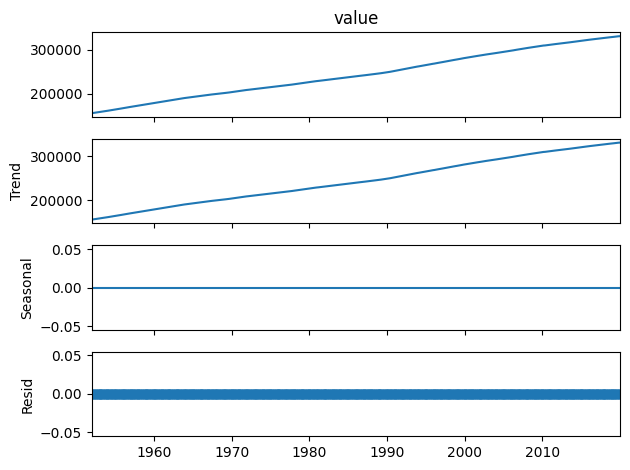

ADF Statistic: -0.7428261319978086, P-value: 0.8353426471630179
The time series is not stationary. Differencing might be needed.


In [51]:
# Check for non-seasonality using decomposition
#decomposition = seasonal_decompose(df_resampled.dropna(), model='additive', period=365)
#decomposition = seasonal_decompose(df_resampled_m.dropna(), model='additive', period=12)
decomposition = seasonal_decompose(df_resampled_y.dropna(), model='additive', period=1)
decomposition.plot()
plt.show()

# ADF Test to confirm stationarity
#adf_result = adfuller(df_resampled.dropna())
#adf_result = adfuller(df_resampled_m.dropna())
adf_result = adfuller(df_resampled_y.dropna())
print(f"ADF Statistic: {adf_result[0]}, P-value: {adf_result[1]}")

if adf_result[1] < 0.05:
    print("The time series is stationary.")
else:
    print("The time series is not stationary. Differencing might be needed.")

In [52]:
# Train-test split
train_size = int(len(df_resampled) * 0.8)
train, test = df_resampled.iloc[:train_size], df_resampled.iloc[train_size:]


In [53]:

# SARIMA model for forecasting
sarima_model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(0, 0, 0, 0))
sarima_result = sarima_model.fit(disp=False)

In [54]:
# Prepare data for XGBoost and LSTM
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_resampled.values.reshape(-1, 1))

def create_features(data, look_back):
    X, y = [], []
    for i in range(look_back, len(data)):
        X.append(data[i-look_back:i])
        y.append(data[i])
    return np.array(X), np.array(y)

look_back = 5
X, y = create_features(scaled_data, look_back)

X_train, X_test = X[:train_size - look_back], X[train_size - look_back:]
y_train, y_test = y[:train_size - look_back], y[train_size - look_back:]


In [55]:
# Optuna for XGBoost
def xgb_objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
    }
    xgb_model = XGBRegressor(**params)
    xgb_model.fit(X_train.reshape(X_train.shape[0], -1), y_train.ravel())
    preds = xgb_model.predict(X_test.reshape(X_test.shape[0], -1))
    return mean_squared_error(y_test, preds)

study = optuna.create_study(direction="minimize")
study.optimize(xgb_objective, n_trials=20)
best_xgb_params = study.best_params
print(f"Best XGBoost parameters: {best_xgb_params}")

# Train XGBoost with optimized parameters
xgb_model = XGBRegressor(**best_xgb_params)
xgb_model.fit(X_train.reshape(X_train.shape[0], -1), y_train.ravel())

[I 2024-12-03 03:27:17,304] A new study created in memory with name: no-name-4617290f-dae5-4dc9-8162-e894f7cb6aa4
[I 2024-12-03 03:27:17,585] Trial 0 finished with value: 0.012449627070415569 and parameters: {'n_estimators': 217, 'max_depth': 6, 'learning_rate': 0.11609722427365181, 'subsample': 0.593331880708172, 'colsample_bytree': 0.6313159168000886}. Best is trial 0 with value: 0.012449627070415569.
[I 2024-12-03 03:27:17,807] Trial 1 finished with value: 0.01244764738108921 and parameters: {'n_estimators': 224, 'max_depth': 8, 'learning_rate': 0.15750934825219487, 'subsample': 0.7107544296540345, 'colsample_bytree': 0.6248222705399566}. Best is trial 1 with value: 0.01244764738108921.
[I 2024-12-03 03:27:17,979] Trial 2 finished with value: 0.012476608517485624 and parameters: {'n_estimators': 214, 'max_depth': 3, 'learning_rate': 0.1017731665611737, 'subsample': 0.7111012606903002, 'colsample_bytree': 0.5738340017503043}. Best is trial 1 with value: 0.01244764738108921.
[I 2024-1

Best XGBoost parameters: {'n_estimators': 186, 'max_depth': 8, 'learning_rate': 0.24905341272737622, 'subsample': 0.6333517583151531, 'colsample_bytree': 0.9257577040829219}


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9257577040829219, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.24905341272737622, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=186, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [56]:
# LSTM Model
X_lstm_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_lstm_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

lstm_model = Sequential([
    Input(shape=(look_back, 1)),
    LSTM(50, return_sequences=True),
    LSTM(50),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_lstm_train, y_train, epochs=10, batch_size=32, verbose=0)


In [58]:
# Set forecast horizon to the smaller of 100 or the length of the test set
seasonal_period = 6  # One day for hourly dat
forecast_horizon = 100 * seasonal_period  # 100 full periods
print(f"Forecast horizon: {forecast_horizon}")

# SARIMA forecasting
sarima_forecast = sarima_result.forecast(steps=forecast_horizon)
print(len(sarima_forecast))
# Direct XGBoost prediction
y_pred_xgb = xgb_model.predict(X_test[:forecast_horizon].reshape(forecast_horizon, -1))
y_pred_xgb = scaler.inverse_transform(y_pred_xgb.reshape(-1, 1))

# Direct LSTM prediction
# Direct LSTM prediction
y_pred_lstm = lstm_model.predict(X_test[:forecast_horizon].reshape(forecast_horizon, look_back, 1))
y_pred_lstm = scaler.inverse_transform(y_pred_lstm)

# Ensure forecasts are the same length as test[:forecast_horizon]
sarima_forecast = sarima_forecast[:forecast_horizon]
y_pred_xgb = y_pred_xgb[:forecast_horizon]
y_pred_lstm = y_pred_lstm[:forecast_horizon]


Forecast horizon: 600
600
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


SARIMA MSE: 218267.5918278663, MAE: 404.4103570668972, R2: 0.8923061482653188
XGBoost MSE: 9682372.396124749, MAE: 2766.8810887096774, R2: -3.777310128984076
LSTM MSE: 20921.48751830581, MAE: 141.9912970430106, R2: 0.9896772784452477


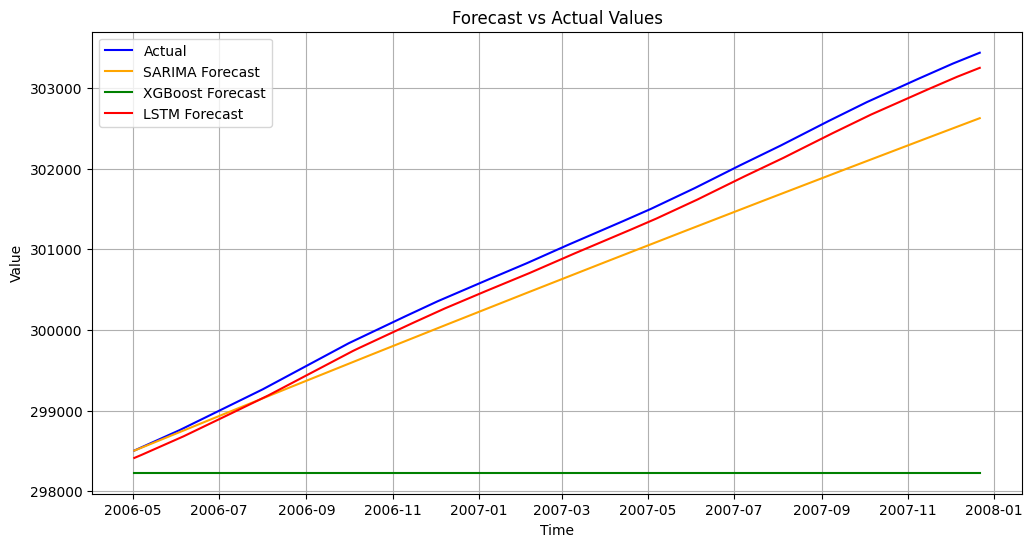

In [59]:
# Evaluation
test_actual = test.values[:forecast_horizon]

mse_sarima = mean_squared_error(test_actual, sarima_forecast)
mse_xgb = mean_squared_error(test_actual, y_pred_xgb)
mse_lstm = mean_squared_error(test_actual, y_pred_lstm.flatten())

mae_sarima = mean_absolute_error(test_actual, sarima_forecast)
mae_xgb = mean_absolute_error(test_actual, y_pred_xgb)
mae_lstm = mean_absolute_error(test_actual, y_pred_lstm.flatten())

r2_sarima = r2_score(test_actual, sarima_forecast)
r2_xgb = r2_score(test_actual, y_pred_xgb)
r2_lstm = r2_score(test_actual, y_pred_lstm.flatten())

print(f"SARIMA MSE: {mse_sarima}, MAE: {mae_sarima}, R2: {r2_sarima}")
print(f"XGBoost MSE: {mse_xgb}, MAE: {mae_xgb}, R2: {r2_xgb}")
print(f"LSTM MSE: {mse_lstm}, MAE: {mae_lstm}, R2: {r2_lstm}")

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(test.index[:forecast_horizon], test_actual, label="Actual", color="blue")
plt.plot(test.index[:forecast_horizon], sarima_forecast, label="SARIMA Forecast", color="orange")
plt.plot(test.index[:forecast_horizon], y_pred_xgb, label="XGBoost Forecast", color="green")
plt.plot(test.index[:forecast_horizon], y_pred_lstm.flatten(), label="LSTM Forecast", color="red")
plt.legend()
plt.title("Forecast vs Actual Values")
plt.xlabel("Time")
plt.ylabel("Value")
plt.grid()
plt.show()

In [61]:

# Save SARIMA model
joblib.dump(sarima_result, 'sarima_model.pkl')

# Save the XGBoost model
joblib.dump(xgb_model, 'xgb_model.pkl')

# Save the LSTM model
lstm_model.save('lstm_model.keras')

# Load and reproduce predictions using the saved models

# Load the SARIMA model
sarima_result_loaded = joblib.load('sarima_model.pkl')

# Load the XGBoost model
xgb_model_loaded = joblib.load('xgb_model.pkl')

# Load the LSTM model
lstm_model_loaded = load_model('lstm_model.keras')


Forecast horizon: 600
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Loaded SARIMA MSE: 218267.5918278663, MAE: 404.4103570668972, R2: 0.8923061482653188
Loaded XGBoost MSE: 9682372.396124749, MAE: 2766.8810887096774, R2: -3.777310128984076
Loaded LSTM MSE: 20921.48751830581, MAE: 141.9912970430106, R2: 0.9896772784452477


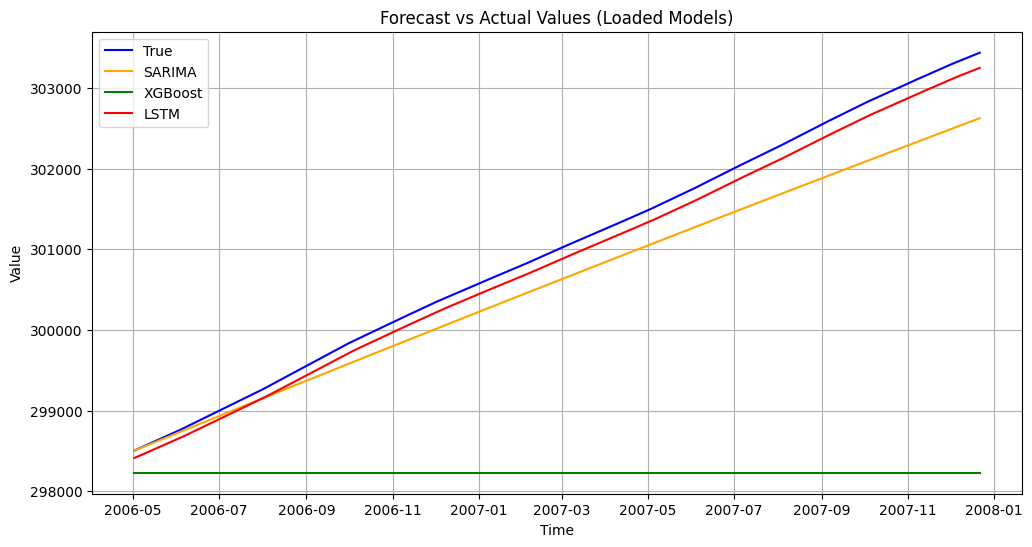

In [62]:
# Forecast horizon (ensure it matches the test set)
seasonal_period = 6  # One day for hourly dat
forecast_horizon = 100 * seasonal_period  # 100 full periods
print(f"Forecast horizon: {forecast_horizon}")

# SARIMA predictions (forecasting for `forecast_horizon` steps)
predictions_sarima_loaded = sarima_result_loaded.forecast(steps=forecast_horizon)

# XGBoost predictions (forecasting for `forecast_horizon` steps)
predictions_xgb_loaded = xgb_model_loaded.predict(X_test[:forecast_horizon].reshape(forecast_horizon, -1))
predictions_xgb_loaded = scaler.inverse_transform(predictions_xgb_loaded.reshape(-1, 1))

# LSTM predictions (forecasting for `forecast_horizon` steps)
predictions_lstm_loaded = lstm_model_loaded.predict(X_test[:forecast_horizon].reshape(forecast_horizon, look_back, 1))
predictions_lstm_loaded = scaler.inverse_transform(predictions_lstm_loaded)

# Evaluation of the loaded models
test_actual = test.values[:forecast_horizon]

mse_sarima_loaded = mean_squared_error(test_actual, predictions_sarima_loaded)
mse_xgb_loaded = mean_squared_error(test_actual, predictions_xgb_loaded)
mse_lstm_loaded = mean_squared_error(test_actual, predictions_lstm_loaded.flatten())

mae_sarima_loaded = mean_absolute_error(test_actual, predictions_sarima_loaded)
mae_xgb_loaded = mean_absolute_error(test_actual, predictions_xgb_loaded)
mae_lstm_loaded = mean_absolute_error(test_actual, predictions_lstm_loaded.flatten())

r2_sarima_loaded = r2_score(test_actual, predictions_sarima_loaded)
r2_xgb_loaded = r2_score(test_actual, predictions_xgb_loaded)
r2_lstm_loaded = r2_score(test_actual, predictions_lstm_loaded.flatten())

# Print evaluation results
print(f"Loaded SARIMA MSE: {mse_sarima_loaded}, MAE: {mae_sarima_loaded}, R2: {r2_sarima_loaded}")
print(f"Loaded XGBoost MSE: {mse_xgb_loaded}, MAE: {mae_xgb_loaded}, R2: {r2_xgb_loaded}")
print(f"Loaded LSTM MSE: {mse_lstm_loaded}, MAE: {mae_lstm_loaded}, R2: {r2_lstm_loaded}")

# Plot results for loaded models
plt.figure(figsize=(12, 6))
plt.plot(test.index[:forecast_horizon], test_actual, label='True', color='blue')
plt.plot(test.index[:forecast_horizon], predictions_sarima_loaded, label='SARIMA', color='orange')
plt.plot(test.index[:forecast_horizon], predictions_xgb_loaded, label='XGBoost', color='green')
plt.plot(test.index[:forecast_horizon], predictions_lstm_loaded.flatten(), label='LSTM', color='red')
plt.legend()
plt.title("Forecast vs Actual Values (Loaded Models)")
plt.xlabel("Time")
plt.ylabel("Value")
plt.grid()
plt.show()
